<a href="https://colab.research.google.com/github/AshsmashR/trial-codes/blob/main/CNNtrial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [ ]:
import kagglehub

path = kagglehub.dataset_download("raddar/chest-xrays-indiana-university")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-xrays-indiana-university


In [ ]:
import os

# List the downloaded dataset folder
for root, dirs, files in os.walk(path):
    print(root)
    for f in files:
        print("  └──", f)


Streaming output truncated to the last 5000 lines.
  └── 1980_IM-0637-1001.dcm.png
  └── 1204_IM-0138-2001.dcm.png
  └── 3410_IM-1648-1001.dcm.png
  └── 3809_IM-1919-1003002.dcm.png
  └── 1839_IM-0543-12013.dcm.png
  └── 2137_IM-0759-1001.dcm.png
  └── 1396_IM-0252-2001.dcm.png
  └── 897_IM-2406-1001.dcm.png
  └── 390_IM-1979-1001.dcm.png
  └── 901_IM-2409-1001.dcm.png
  └── 1516_IM-0334-1001.dcm.png
  └── 3006_IM-1388-1001.dcm.png
  └── 3514_IM-1715-1001.dcm.png
  └── 2060_IM-0698-1001.dcm.png
  └── 3400_IM-1644-2001.dcm.png
  └── 1576_IM-0375-2001.dcm.png
  └── 3701_IM-1848-1001.dcm.png
  └── 3843_IM-1944-3001.dcm.png
  └── 462_IM-2090-1001.dcm.png
  └── 867_IM-2387-1001.dcm.png
  └── 3185_IM-1503-1001.dcm.png
  └── 3541_IM-1733-0001-0001.dcm.png
  └── 2016_IM-0665-1001.dcm.png
  └── 3405_IM-1647-2001.dcm.png
  └── 2839_IM-1252-1001.dcm.png
  └── 324_IM-1534-2001.dcm.png
  └── 1082_IM-0058-1001.dcm.png
  └── 2975_IM-1364-1001.dcm.png
  └── 3244_IM-1536-1001.dcm.png
  └── 2270_IM-0859

In [ ]:
import pandas as pd
import os

BASE_DIR = "/kaggle/input/chest-xrays-indiana-university"
PROJ_CSV = os.path.join(BASE_DIR, "indiana_projections.csv")
REPORT_CSV = os.path.join(BASE_DIR, "indiana_reports.csv")

# Load both files
projections = pd.read_csv(PROJ_CSV)
reports = pd.read_csv(REPORT_CSV)

print("Projections shape:", projections.shape)
print("Reports shape:", reports.shape)
print("Projections columns:", projections.columns)
print("Reports columns:", reports.columns)


Projections shape: (7466, 3)
Reports shape: (3851, 8)
Projections columns: Index(['uid', 'filename', 'projection'], dtype='object')
Reports columns: Index(['uid', 'MeSH', 'Problems', 'image', 'indication', 'comparison',
       'findings', 'impression'],
      dtype='object')


In [ ]:
# Merge projections and reports on 'uid'
meta = projections.merge(reports, on='uid', how='left')

print("Merged shape:", meta.shape)
meta[['uid', 'filename', 'projection']].head()


Merged shape: (7466, 10)


,uid,filename,projection
0,1,1_IM-0001-4001.dcm.png,Frontal
1,1,1_IM-0001-3001.dcm.png,Lateral
2,2,2_IM-0652-1001.dcm.png,Frontal
3,2,2_IM-0652-2001.dcm.png,Lateral
4,3,3_IM-1384-1001.dcm.png,Frontal


In [ ]:
IMAGE_DIR = os.path.join(BASE_DIR, "images", "images_normalized")

# Create full path for each image
meta['filepath'] = meta['filename'].apply(lambda f: os.path.join(IMAGE_DIR, f))


In [ ]:
# Check which filepaths actually exist
meta['file_exists'] = meta['filepath'].map(os.path.exists)

# Filter only valid rows
meta = meta[meta['file_exists']].reset_index(drop=True)
print(f"✅ Total valid images: {len(meta)}")


✅ Total valid images: 7466


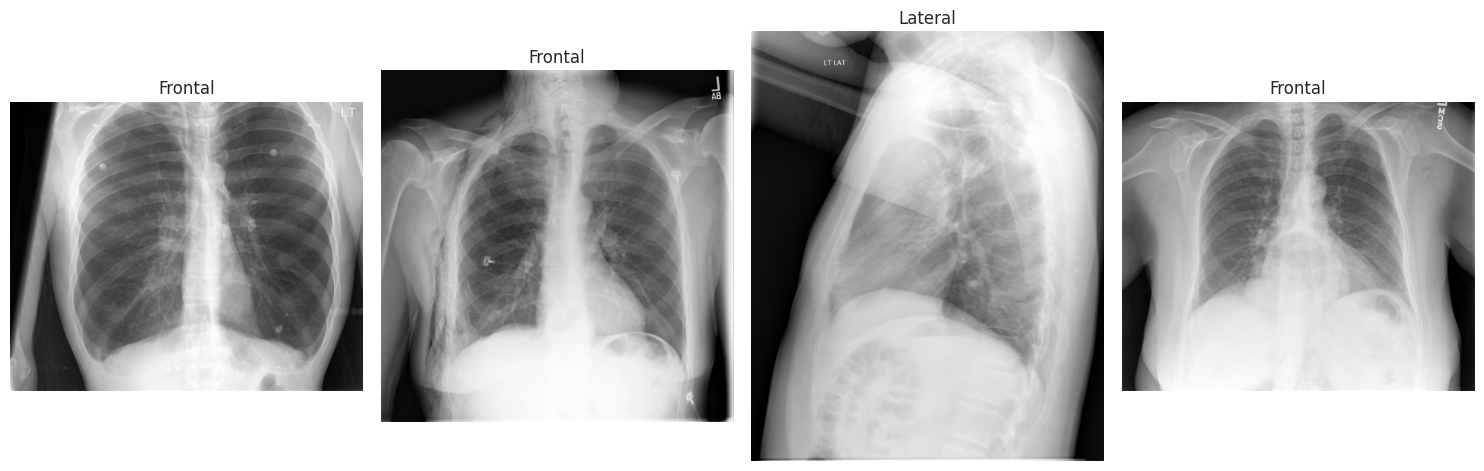

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def plot_samples(df, n=4):
    sample = df.sample(n, random_state=42)
    plt.figure(figsize=(15, 5))
    for i in range(n):
        img = Image.open(sample.iloc[i]['filepath'])
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(sample.iloc[i]['projection'])
        plt.axis('off')
    plt.tight_layout()
    plt.show()
plot_samples(meta)


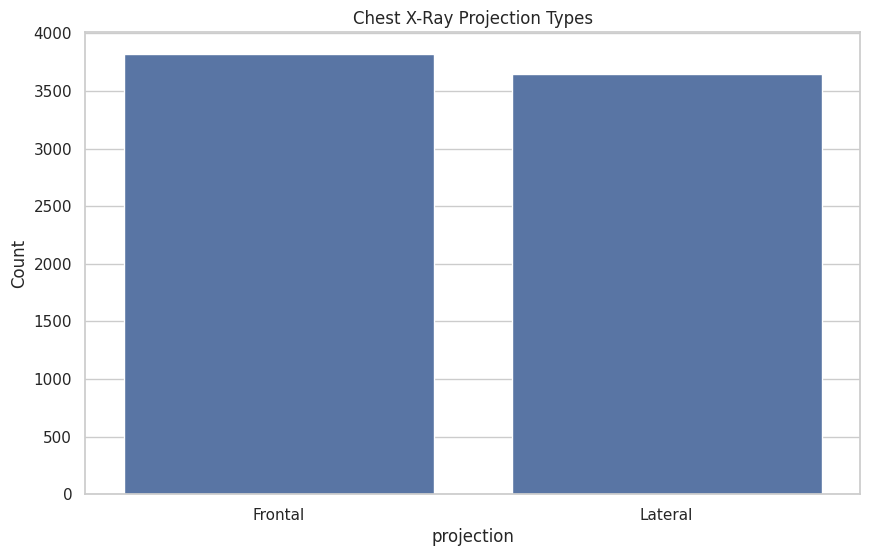

In [ ]:
import seaborn as sns

sns.countplot(data=meta, x='projection',
              order=meta['projection'].value_counts().index)
plt.title('Chest X-Ray Projection Types')
plt.ylabel('Count')
plt.show()


In [ ]:
from sklearn.preprocessing import LabelEncoder


In [ ]:
le = LabelEncoder()
meta['label'] = le.fit_transform(meta['projection'])

# Show label mapping
print("Class labels:", list(le.classes_))
meta[['projection', 'label']].head()


Class labels: ['Frontal', 'Lateral']


,projection,label
0,Frontal,0
1,Lateral,1
2,Frontal,0
3,Lateral,1
4,Frontal,0


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset



class ChestXrayDataset(Dataset):
    def __init__(self, df, transforms=None):
        self.df = df.reset_index(drop=True)
        self.transforms = transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img = Image.open(row['filepath']).convert('RGB')  # ✅ RGB conversion
        label = torch.tensor(row['label'], dtype=torch.float32)

        if self.transforms:
            img = self.transforms(img)

        return img, label


In [ ]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import torchvision.transforms as T

def create_data_loaders(meta_df, batch_size=32, img_size=224, val_test_split=0.3, seed=42):
    # Split meta into train / val / test
    train_df, temp_df = train_test_split(meta_df, test_size=val_test_split, stratify=meta_df['label'], random_state=seed)
    val_df, test_df = train_test_split(temp_df, test_size=0.3, stratify=temp_df['label'], random_state=seed)

    print(f"Train: {len(train_df)}")
    print(f"Validation: {len(val_df)}")
    print(f"Test: {len(test_df)}")

    # ✅ RGB transforms for 3-channel input
    train_transforms = T.Compose([
        T.Resize((img_size, img_size)),
        T.RandomHorizontalFlip(),
        T.RandomRotation(10),
        T.ToTensor(),
        T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize 3 channels
    ])

    val_test_transforms = T.Compose([
        T.Resize((img_size, img_size)),
        T.ToTensor(),
        T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    # Create dataset instances
    train_ds = ChestXrayDataset(train_df, transforms=train_transforms)
    val_ds   = ChestXrayDataset(val_df, transforms=val_test_transforms)
    test_ds  = ChestXrayDataset(test_df, transforms=val_test_transforms)

    # Create data loaders
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    return train_loader, val_loader, test_loader, train_df, val_df, test_df


In [ ]:
train_loader, val_loader, test_loader, train_df, val_df, test_df = create_data_loaders(meta)
print(len(train_df), len(val_df), len(test_df))

Train: 5226
Validation: 1568
Test: 672
5226 1568 672


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

In [ ]:
class ChestXRayClassifier(nn.Module):
    def __init__(self):
        super(ChestXRayClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)

        self.fc1 = nn.Linear(256 * 14 * 14, 512)  # For 224x224 input
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        return self.fc3(x)  # no sigmoid here

# ----------------------------

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = ChestXRayClassifier().to(device)
criterion = nn.BCEWithLogitsLoss()  # better numerically than sigmoid+BCELoss
optimizer = optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)


Using device: cuda


In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

class EarlyStopping:
    def __init__(self, patience=3, delta=0.001):
        self.patience = patience
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                print("⏹️ Early stopping triggered.")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

def train_model(model, criterion, optimizer, train_loader, val_loader, device, epochs=20):
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5, verbose=True)
    early_stopper = EarlyStopping(patience=3)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(1, epochs + 1):
        model.train()
        running_loss, correct, total = 0, 0, 0

        for imgs, labels in train_loader:
            imgs = imgs.to(device)
            labels = labels.to(device).unsqueeze(1).float()

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.to(device)
                labels = labels.to(device).unsqueeze(1).float()
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * imgs.size(0)
                preds = (torch.sigmoid(outputs) > 0.5).float()
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch}/{epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        scheduler.step(val_loss)
        early_stopper(val_loss)
        if early_stopper.early_stop:
            break

    return train_losses, train_accs, val_losses, val_accs


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [ ]:
# 4. Evaluation Function
def evaluate_model(model, test_loader, device):
    model.eval()
    y_true, y_pred, y_prob = [], [], []
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.unsqueeze(1).float().to(device)
            logits = model(x)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()

            y_true += y.cpu().numpy().tolist()
            y_pred += preds.cpu().numpy().tolist()
            y_prob += probs.cpu().numpy().tolist()

    print(classification_report(y_true, y_pred, target_names=["Frontal", "Lateral"]))
    auc = roc_auc_score(y_true, y_prob)
    print(f"AUC: {auc:.4f}")

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
    plt.plot([0, 1], [0, 1], '--')
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()


In [ ]:
# 5. Plotting Training Curve
def plot_training_curves(train_losses, train_accs, val_losses, val_accs):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/5 | Train Loss: 0.1198, Acc: 0.9539 | Val Loss: 0.0183, Acc: 0.9936
Epoch 2/5 | Train Loss: 0.0290, Acc: 0.9914 | Val Loss: 0.0200, Acc: 0.9962
Epoch 3/5 | Train Loss: 0.0232, Acc: 0.9923 | Val Loss: 0.0142, Acc: 0.9955
Epoch 4/5 | Train Loss: 0.0136, Acc: 0.9956 | Val Loss: 0.0105, Acc: 0.9981
Epoch 5/5 | Train Loss: 0.0127, Acc: 0.9954 | Val Loss: 0.0127, Acc: 0.9974
              precision    recall  f1-score   support

     Frontal       1.00      0.99      1.00       344
     Lateral       0.99      1.00      1.00       328

    accuracy                           1.00       672
   macro avg       1.00      1.00      1.00       672
weighted avg       1.00      1.00      1.00       672

AUC: 1.0000


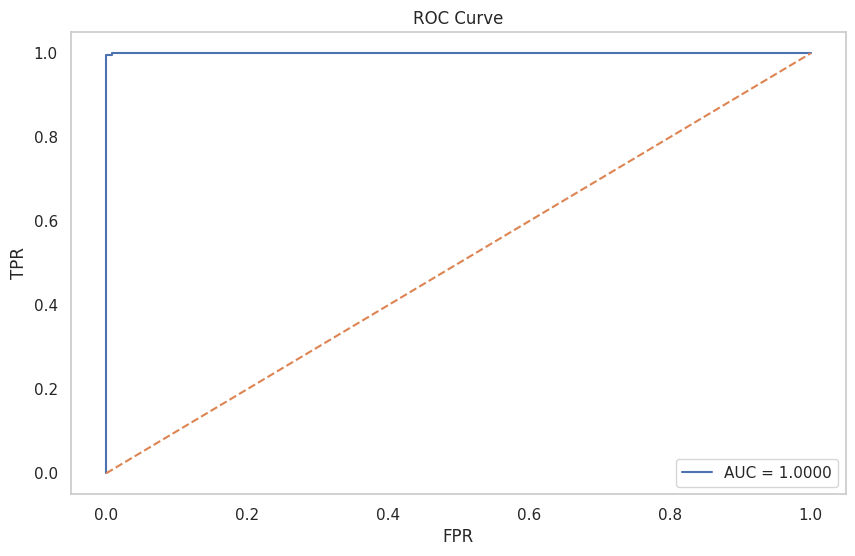

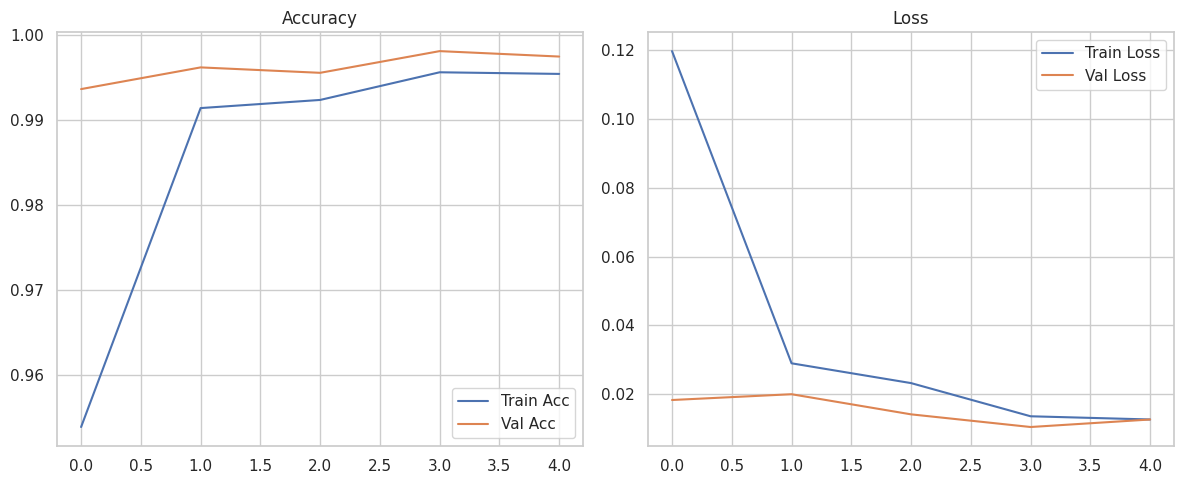

In [ ]:
# Setup
model = ChestXRayClassifier().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

# Training
train_losses, train_accs, val_losses, val_accs = train_model(
    model, criterion, optimizer, train_loader, val_loader, device, epochs=5
)

evaluate_model(model, test_loader, device)

# Plot Curves
plot_training_curves(train_losses, train_accs, val_losses, val_accs)


In [ ]:
# Save model
torch.save(model, '2chest_xray_projection_classifier.pt')

# To load later:
# model = torch.load('chest_xray_projection_classifier.pt')
# model.eval()


In [ ]:
from PIL import Image
import torchvision.transforms as T
import torch

# Image path
image_path = '/content/download.jpeg'

# Define same transforms as validation
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # RGB mean and std
])

# Load and preprocess image
img = Image.open(image_path).convert('RGB')
img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dim

# Model in eval mode
model.eval()
with torch.no_grad():
    output = model(img_tensor)
    prob = torch.sigmoid(output).item()
    pred = 1 if prob > 0.5 else 0

# Output
print(f"Predicted Class: {'Lateral' if pred else 'Frontal'} | Probability: {prob:.4f}")


Predicted Class: Lateral | Probability: 1.0000


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model(imgs)
        preds = (outputs > 0.5).int().squeeze()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


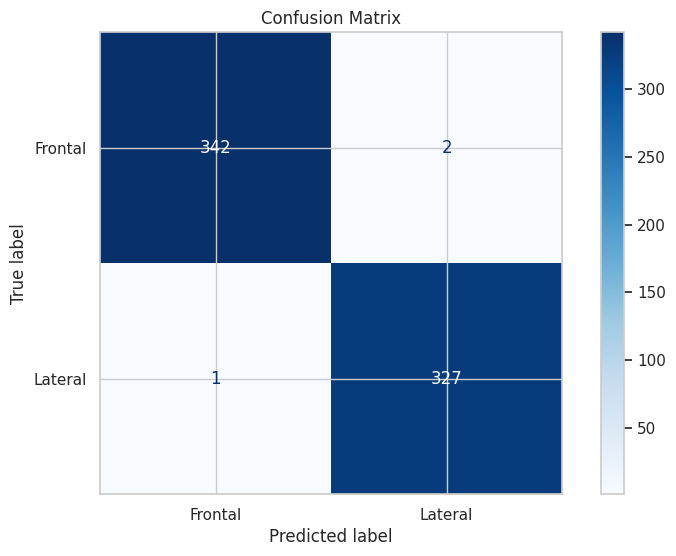

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Frontal', 'Lateral'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
